# Анализ активности студентов онлайн курса Анализ данных в R

In [1]:
#Мы работаем аналитиком в Stepic
#Проблема: Большой разрыв между количеством начавших проходить курс, и закончивших этот курс( в среднем 5-10% по индустрии)
#Наши задачи ответить на два вопроса:
#Понять почему это происходит?
#Что нужно сделать, чтобы эту ситуацию улучшить, не меняя курс?

In [2]:
#Чтобы решить задачу, надо проанализировать действия студентов на всех этапах, найти причинно-следственные связи.

In [3]:
#Все студенты делятся на два класса: 
#1)Окончившие курс - 5-10%
#2)Неокончившие курс - 90-95%
#Если мы обучим модель предсказывать в самом начале обучения студента(например по активности в первые дни) -
#закончит он курс или нет, тогда эту информацию можно использовать, чтобы воздействовать на студента, и изменить его решение

# 1. Обработка, подготовка данных (Data Preprocessing, feature engineering)

In [4]:
import pandas as pd
import numpy as np

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events_data = pd.read_csv('event_data_train.csv')

In [7]:
#сначала мы получаем сырые данные
events_data.head(10) 
#timestamp - unixdate - это количество секунд, который прошли с 01.01.1970г
#Ссылки для работы с датой:
#https://medium.com/datadriveninvestor/how-to-work-with-dates-in-pandas-like-a-pro-a84055a4819d
#https://www.geeksforgeeks.org/python-working-with-date-and-time-using-pandas/
#https://python-scripts.com/datetime-time-python
#https://pythonworld.ru/obrabotka-dannyx/pandas-cookbook-7.html

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [8]:
events_data[events_data.user_id == 17632]

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
2516082,31977,1505649526,viewed,17632
2516083,31976,1505649530,viewed,17632
2516084,31972,1505649532,viewed,17632
2516085,31971,1505649536,viewed,17632


In [9]:
#Самый пер этап exploration data - мини исследование данных, проверка вообще те ли это данные

In [10]:
events_data.action.unique() #проверяем количество вариантов в action
#'viewed' - просмотрел
#'discovered' - впервые увидел
#'started_attempt' - начал решать
#'passed' - решил

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [11]:
#Переводим timestamp в стандартную дату

In [12]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [13]:
events_data.date.min() #смотрим минимальную дату
events_data.date.max() #смотрим максимальную дату

Timestamp('2018-05-19 23:33:31')

In [14]:
events_data.step_id.nunique() #количество степов 

198

In [15]:
events_data['day'] = events_data.date.dt.date #день

In [16]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [17]:
sns.set(rc={'figure.figsize':(9,6)}) #изменяем дефолтный размер графика, чтобы дата помещялась на оси х

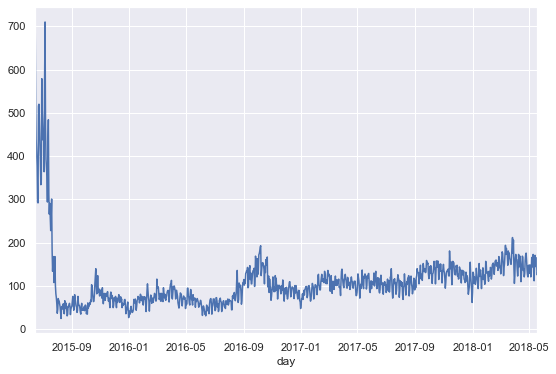

In [18]:
events_data.groupby('day').user_id.nunique().plot() #смотрим количество уникальных пользователей для каждого дня
#проверяем наши данные, базовая проверка

In [19]:
#Посмотрим, как распределены пользователи по количеству баллов, которые они получили за курс


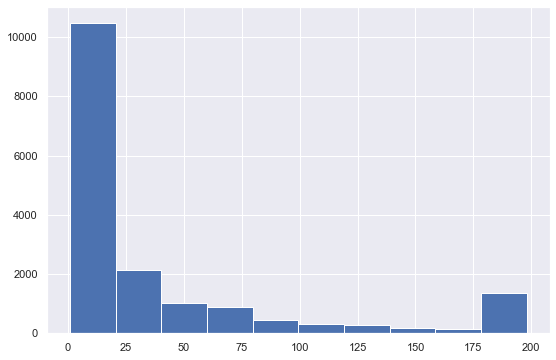

In [20]:
events_data[events_data.action == 'passed']\
    .groupby('user_id', as_index = False)\
    .agg({'step_id':'count'})\
    .rename(columns={'step_id':'passed_steps'})\
    .passed_steps.hist() 
#берем сданные степы
#группируем по пользователям
#считаем количество для каждого степа
#переименовываем колонки
#смотрим распределение
#Пользователи, у которых нет ни одного passed стэпа вообще не попадут в результат

In [21]:
#чтобы учесть пользователей, у которых 0 сданных степов воспользуемся методом pivot_table
users_events_data = events_data.pivot_table(index = 'user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

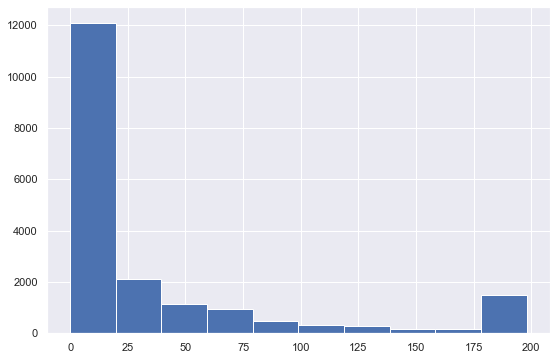

In [22]:
#чтобы учесть пользователей, у которых 0 сданных степов воспользуемся методом pivot_table
events_data.pivot_table(index = 'user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().discovered.hist()

In [23]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [24]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [25]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date #день

In [26]:
#чтобы учесть пользователей, у которых 0 сданных степов воспользуемся методом pivot_table
users_scores = submissions_data.pivot_table(index = 'user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [27]:
users_scores[users_scores.correct == users_scores.correct.max()]

submission_status,user_id,correct,wrong
439,1046,421,513


In [28]:
users_scores.correct.max()

421

In [29]:
#Для каждого пользователя посчитаем:
#1)Сколько у него было уникальных степов
#2)Сколько он отправил правильных сабмитов
#3)Cколько он отправил неправильных сабмитов
#4)Сколько дней он учился на Степике
#5)Сравним, отличаются ли эти показатели у пользователей, которые успешно прошли курс и не прошли его
#6)Надо понять какой пользователь действительно бросил курс, а какой его еще продолжит
#1 категория: сдавшие курс, 2 категория: в процессе сдачи, 3 категория: не сдаст никогда
#для этого посчитаем отклонение по перерывам между сабмишнами, и решим какой перерыв статистически значим

In [30]:
#Рассчитаем промежутки между днями, когда пользователь проходил курс

In [31]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [32]:
#убюирает одинаковые user_id', 'day'
gap_data = events_data[['user_id', 'day', 'timestamp']]\
    .drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [33]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))

In [34]:
gap_data = gap_data/(24*60*60)

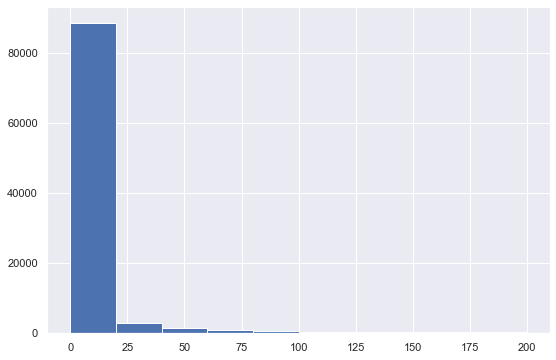

In [35]:
gap_data[gap_data<200].hist()

In [36]:
gap_data.quantile(0.95) # 95% пользователей не возвращаются на курс после 2 месяцев

59.760440972222156

In [37]:
gap_data.quantile(0.90) # 90% пользователей не возвращаются на курс после 18

18.325995370370403

In [38]:
#используем значение 30 дней отсутствия на курсе, чтобы отнести пользователя к категории дропнувшихся

In [358]:
users_data = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})    #последнее посещение курса

In [359]:
now = 1526772811          #дата на конец исследования
drop_out_threshold = 2592000 #один месяц в секундах

In [360]:
users_data.last_timestamp

0        1472827464
1        1519226966
2        1444581588
3        1499859939
4        1521634660
            ...    
19229    1517495987
19230    1510225034
19231    1512035039
19232    1509995096
19233    1520978742
Name: last_timestamp, Length: 19234, dtype: int64

In [361]:
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [362]:
users_data['is_gone_user'] = (now - users_data.last_timestamp)>drop_out_threshold 
users_data       #определелили пользователей, которые больше не вернутся, но надо понять прошли они курс или нет

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [363]:
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [353]:
users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer').head() 
#объединяем фреймы с корректно сданными степами и с паузой в занятиях
#по умолчанию merge запускается с параметром inner, чтобы не потерять данные надо указывать outer

In [354]:
users_data = users_data.fillna(0) #заполняем NA значения нулями

In [364]:
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [366]:
users_data = users_data.merge(users_events_data, how = 'outer')

In [368]:
users_data

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed
0,1,1472827464,True,1,0,0,1
1,2,1519226966,True,9,9,2,10
2,3,1444581588,True,91,87,30,192
3,5,1499859939,True,11,11,4,12
4,7,1521634660,True,1,1,0,1
...,...,...,...,...,...,...,...
19229,26790,1517495987,True,8,8,1,9
19230,26793,1510225034,True,1,0,1,1
19231,26794,1512035039,True,69,69,34,180
19232,26797,1509995096,True,10,10,2,13


In [223]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days  #считаем количество уникальных дней для каждого пользователя, переводим серию во фрейм, убираем индексы

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [349]:
users_data = users_data.merge(users_days, how='outer') #объединяем фрейм

In [350]:
users_data.user_id.nunique() == events_data.user_id.nunique() #проверяем что никого не потеряли, сравниваем количество user_id
#в начальном датафрейме и конечном

True

In [371]:
users_data.passed

0         0
1         9
2        87
3        11
4         1
         ..
19229     8
19230     0
19231    69
19232    10
19233    12
Name: passed, Length: 19234, dtype: int64

In [373]:
users_data['passed_course'] = users_data.passed>170 #можно так user_data['passed_corse'].value_counts(normalize=True)

In [376]:
users_data#с учетом прошедших курс

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,1,0,0,1,False
1,2,1519226966,True,9,9,2,10,False
2,3,1444581588,True,91,87,30,192,False
3,5,1499859939,True,11,11,4,12,False
4,7,1521634660,True,1,1,0,1,False
...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,8,8,1,9,False
19230,26793,1510225034,True,1,0,1,1,False
19231,26794,1512035039,True,69,69,34,180,False
19232,26797,1509995096,True,10,10,2,13,False


In [433]:
users_data.to_csv('users_data.csv')

In [432]:
users_data.groupby('passed_course').count() # 17809/1425 -  около 8% прошли курс

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed
passed_course,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425


In [229]:
#Статья по merge https://habr.com/ru/post/448072/

In [230]:
#Проблема: Наша модель должна научиться, как можно раньше(!) предсказывать дропнется человек с курса или нет
#возьмем первую неделю или несколько дней данных каждого пользователя и по ним попробуем предсказать пройдет он курс или нет
#этим мы займемся во втором модуле

# Предсказать: пройдет ли пользователь курс, по 5 дням активности

In [231]:
#Выбираем количество дней за которые мы хотим предсказать исход
users_data[users_data.passed_course].day.median() #медианная продолжительность прохождения курса - 20 дней

20.0

In [232]:
#Отбираем события, которые происходили в течение 3 дней для каждого пользователя, готовим данные для обучения
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'})\
    .rename({'timestamp':'min_timestamp'}, axis=1)
#начало действий юзера на курсе

In [233]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [234]:
users_data = users_data.merge(user_min_time, how='outer')

In [235]:
events_data_train = events_data

In [236]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str) #сшили id и timestamp

In [237]:
events_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [238]:
learning_time_threshold = 3 * 24 * 60 * 60

In [239]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [240]:
user_learning_time_threshold

0            1_1473086664
1            2_1514642564
2            3_1434617676
3            5_1466416009
4            7_1521893860
               ...       
19229    26790_1451743216
19230    26793_1510484231
19231    26794_1495546249
19232    26797_1508684516
19233    26798_1521234963
Length: 19234, dtype: object

In [243]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold #объединяем минимальное и максимальное время

In [244]:
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [245]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']],  how='outer')

In [246]:
events_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [247]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold] #фильтруем

In [248]:
events_data_train

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [249]:
submissions_data[submissions_data.submission_status == 'wrong']\
.groupby('step_id').agg({'submission_status':'count'})\
.sort_values(by='submission_status', ascending=False)

,submission_status
step_id,
31978.0,16084
32031.0,13373
32202.0,13002
33481.0,10300
32075.0,10003
...,...
33482.0,707
33681.0,703
33362.0,673


In [250]:
submissions_data[submissions_data.submission_status == 'wrong']\
.step_id.value_counts()

31978.0    16084
32031.0    13373
32202.0    13002
33481.0    10300
32075.0    10003
           ...  
33482.0      707
33681.0      703
33362.0      673
32175.0      342
32929.0       85
Name: step_id, Length: 76, dtype: int64

# Проверка обработки

In [251]:
events_data_train.groupby('user_id').day.nunique().max() #максимальное число дней в датафрейме после обработки

4

In [305]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

# Отбираем фичи

In [410]:
X = submissions_data_train.groupby('user_id')\
.day\
.nunique()\
.to_frame()\
.reset_index()\
.rename(columns={'day':'days'})
#добавляем количество дней на курсе

In [411]:
X #будем постепенно дополнять этот датафрейм

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [412]:
step_tried =  submissions_data_train.groupby('user_id')\
.step_id\
.nunique()\
.to_frame()\
.reset_index()\
.rename(columns={'step_id':'steps_tried'})
#добавляем количество попыток решения

In [413]:
X = X.merge(step_tried, on='user_id', how='outer')

In [414]:
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [415]:
X.shape

(8913, 3)

In [416]:
X= X.merge(submissions_data_train.pivot_table(index = 'user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [417]:
X['correct_ration'] = X.correct / (X.correct + X.wrong)

In [418]:
X

,user_id,days,steps_tried,correct,wrong,correct_ration
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [419]:
X = X.merge(events_data_train.pivot_table(index = 'user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [420]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [421]:
X = X.fillna(0)

In [422]:
X.shape

(19234, 7)

In [423]:
X

,user_id,days,steps_tried,correct,wrong,correct_ration,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [424]:
X['passed_course'] = users_data.passed_course
X['is_gone_user'] = users_data.is_gone_user

In [425]:
users_data.passed_course

0        False
1        False
2        False
3        False
4        False
         ...  
19229    False
19230    False
19231    False
19232    False
19233    False
Name: passed_course, Length: 19234, dtype: bool

In [426]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [427]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [428]:
y = X.passed_course.map(int)

In [429]:
X = X.drop(['passed_course', 'is_gone_user'], axis = 1)

In [430]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [441]:
X #days	steps_tried	correct	wrong	correct_ration	viewed итоговые фичи

,days,steps_tried,correct,wrong,correct_ration,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [435]:
users_data = pd.read_csv('users_data.csv')

In [440]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

clf = LogisticRegressionCV(cv=5)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.coef_)
print(clf.intercept_)
print(cross_val_score(clf,X_train,y_train,cv=4).mean())

0.926605504587156
[[ 0.00289958  0.00198318  0.00179256 -0.0001747   0.00200273  0.0003155 ]]
[-2.45577876]
0.9193077726650273


In [438]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=4)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

{'max_depth': 3, 'max_leaf_nodes': 6, 'min_samples_leaf': 3, 'min_samples_split': 2} 0.920419810517287


In [439]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 15} 0.920419810517287
